<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Sudden Drop in Player Engagement Data Analysis</span>
</div>


In this project, we delve into the unexpected decline in user engagement within a mobile game to identify potential causes.

Our analytical approach will encompass the following steps:

* Conduct a preliminary review of the data quality, finding any
inconsistencies or inaccuracies encountered.
* Modify data types as needed to better suit our analytical processes.
* Introduce additional columns to facilitate pattern identification and enhance our data visualizations.
* Focus our analysis on the initial 100 levels to maintain a certain level of player activity across these levels.
* Analyze the data from two perspectives: the User Experience (UX) Stage, determined by cumulative playtime, and the individual game Levels, to obtain a thorough understanding from various viewpoints.
* Compile our primary recommendations for optimization and conclude our analysis with a summary of these findings.

<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Packages, Original Data</span>
</div>


In [ ]:
#Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px


# Original Data
data_original = pd.read_csv('/content/PopPuzzle_game_progression_funnel.csv')

<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Data Quality Assesment</span>
</div>


In [ ]:
# Copy Data
data = data_original.copy()

# Create a summary function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    return summ

# Turn Step and Event data to integers
data['Step'] = data['Step'].str.extract('(\d+)').astype(int)
data['Event'] = data['Event'].str.extract('(\d+)').astype(int)

# Control if Step and Event are identical for every row
discrepancy_count = (data['Step'] != data['Event']).sum()
print("Number of rows with discrepancies between 'Step' and 'Level' values :", discrepancy_count)
summary(data)

Number of rows with discrepancies between 'Step' and 'Level' values : 166
data shape: (463, 9)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
Step,int64,0,0.000000,463,1.00,463.00,232.000000,133.800847
Event,int64,0,0.000000,463,1.00,464.00,232.043197,133.872647
Users,int64,0,0.000000,150,1.00,1514.00,92.755940,224.930270
Users Of Step 1 in %,float64,0,0.000000,150,0.07,100.00,6.126350,14.856613
Completion Rate in %,float64,1,0.215983,137,50.00,100.00,98.523874,3.883657
Churn,float64,1,0.215983,39,0.00,131.00,3.274892,11.463238
Churn Rate in %,float64,1,0.215983,137,0.00,50.00,1.476147,3.883666
Avg. Fails per User,float64,1,0.215983,51,0.00,1.01,0.090541,0.155115
Avg. Playtime in s,float64,1,0.215983,128,6.00,190.00,61.900433,37.089194


**Findings:**

In the majority of cases, the values for Step and Level are observed to be identical. However, in 166 out of 463 rows, a discrepancy between these values is noted. Additionally, the last row appears to be missing some column values.

Potential outliers have been identified in the average playtime (in seconds).

Example Discrepancies:

```
"Step 120","Level_98 ","51","3.37","98.04","1","1.96","0.00","33"

"Step 121","Level_99 ","50","3.30","98.00","1","2.00","0.22","54"

"Step 462","Level_463 ","1","0.07","100.00","0","0.00","0.00","140"

"Step 463","Level_464 ","1","0.07"
```


Assumption:

The recurring resolution of discrepancies suggests that they may stem from potential delays in data feeds at specific levels, resulting in misalignments between step and level values.

Actions:

* The dataset will be organized according to the Level value, and the Step column will be disregarded and used as an index instead.
* The last row, which contains missing values, will be removed.

<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Data Preperation</span>
</div>


In addition to the findings previously outlined, we will introduce new columns to streamline the process of pattern recognition.

**New Columns:**

* Average Cumulative Playtime: This column will display the cumulative average
playtime in seconds, calculated to represent the total playtime for an average player.

* UX Stage: Utilizing the Average Cumulative Playtime, we will define various user experience stages, such as FTUE (First Time User Experience), Stage 1, Stage 2, Stage 3, and so forth. The FTUE will encompass the initial 60 seconds of gameplay, with each subsequent stage representing an additional 4 minutes of playtime.

* Anomaly Score: This metric will be applied to identify at what churn rate a level is deemed anomalous considering the positive deviation from the mean, trying to facilitate a better targeted analysis and intervention.

In [ ]:
# Rename Event column as Level
data.rename(columns={'Event': 'Level'}, inplace=True)

# Drop rows with null values (1 row)
data.dropna(inplace=True)

# Change floats to integers
data['Churn'] = data['Churn'].astype(int)
data['Avg. Playtime in s'] = data['Avg. Playtime in s'].astype(int)

# Sort the data
data.sort_values(by='Level', inplace=True)

# Drop 'Step'
data.drop(columns='Step', inplace=True)

In [ ]:
# Creating Cumulative Playtime metric.
data['Cumulative Avg. Playtime'] = data['Avg. Playtime in s'].cumsum()


# Creating UX Stages

# Min and Max Spent time
min_time = data['Avg. Playtime in s'].min()
max_time = data['Avg. Playtime in s'].max()

data['UX Stage'] = np.nan
data['Stage Detail'] = np.nan
# Assign 'FTUE' to the 'UX Stage' column where 'Cumulative Avg. Playtime' < 60
data.loc[data['Cumulative Avg. Playtime'] <= 60, 'UX Stage'] = '0'
data.loc[data['Cumulative Avg. Playtime'] <= 60, 'Stage Detail'] = 'FTUE'
y = 60
z = 300

# Assign 'Stage X' to the stages with 4 minutes interval.
for i in range(len(data)):
    i = i + 1
    data.loc[(data['Cumulative Avg. Playtime'] > y) & (data['Cumulative Avg. Playtime'] <= z), 'UX Stage'] = i
    data.loc[(data['Cumulative Avg. Playtime'] > y) & (data['Cumulative Avg. Playtime'] <= z), 'Stage Detail'] = f'Stage {i} Range: ({y},{z}]'

    y = y + 240
    z = z + 300

# Creating an anomaly Score to measure STD
data['Anomaly Score'] = (data['Churn Rate in %'] - data['Churn Rate in %'].mean()) / data['Churn Rate in %'].std()


In [ ]:
# Focusing on the first 100 levels to sustain populated user data for each level.
data = data[:100]
data.sample(5)

,Level,Users,Users Of Step 1 in %,Completion Rate in %,Churn,Churn Rate in %,Avg. Fails per User,Avg. Playtime in s,Cumulative Avg. Playtime,UX Stage,Stage Detail,Anomaly Score
58,59,182,12.02,97.25,5,2.75,0.27,112,4043,17,"Stage 17 Range: (3900,5100]",0.328003
17,18,696,45.97,90.23,68,9.77,0.01,89,802,4,"Stage 4 Range: (780,1200]",2.135573
28,29,406,26.82,96.06,16,3.94,0.01,62,1576,7,"Stage 7 Range: (1500,2100]",0.634414
3,4,1378,91.02,96.08,54,3.92,0.02,18,51,0,FTUE,0.629264
76,77,129,8.52,96.90,4,3.10,0.27,107,5376,23,"Stage 23 Range: (5340,6900]",0.418124


<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Data Visualization & Exploration</span>
</div>


In this chapter, we will visualize correlations, data distributions, average playtime bucketed into different user experience stages (UX Stage), and perform level-based analysis. Our goal is to identify patterns, outliers, and correlations to establish potential action points.

In [ ]:
summary(data)

data shape: (100, 12)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation
Level,int64,0,0.0,100,1.0,100.0,50.5,29.011492
Users,int64,0,0.0,97,50.0,1514.0,378.88,360.091438
Users Of Step 1 in %,float64,0,0.0,97,3.3,100.0,25.0246,23.784188
Completion Rate in %,float64,0,0.0,89,88.94,100.0,97.0503,2.134922
Churn,int64,0,0.0,39,0.0,131.0,14.39,21.245508
Churn Rate in %,float64,0,0.0,89,0.0,11.06,2.9498,2.13493
Avg. Fails per User,float64,0,0.0,39,0.0,1.01,0.1644,0.213359
Avg. Playtime in s,int64,0,0.0,72,7.0,190.0,73.41,41.410996
Cumulative Avg. Playtime,int64,0,0.0,100,7.0,7341.0,3329.62,2266.337471
UX Stage,object,0,0.0,32,NaN,NaN,NaN,NaN


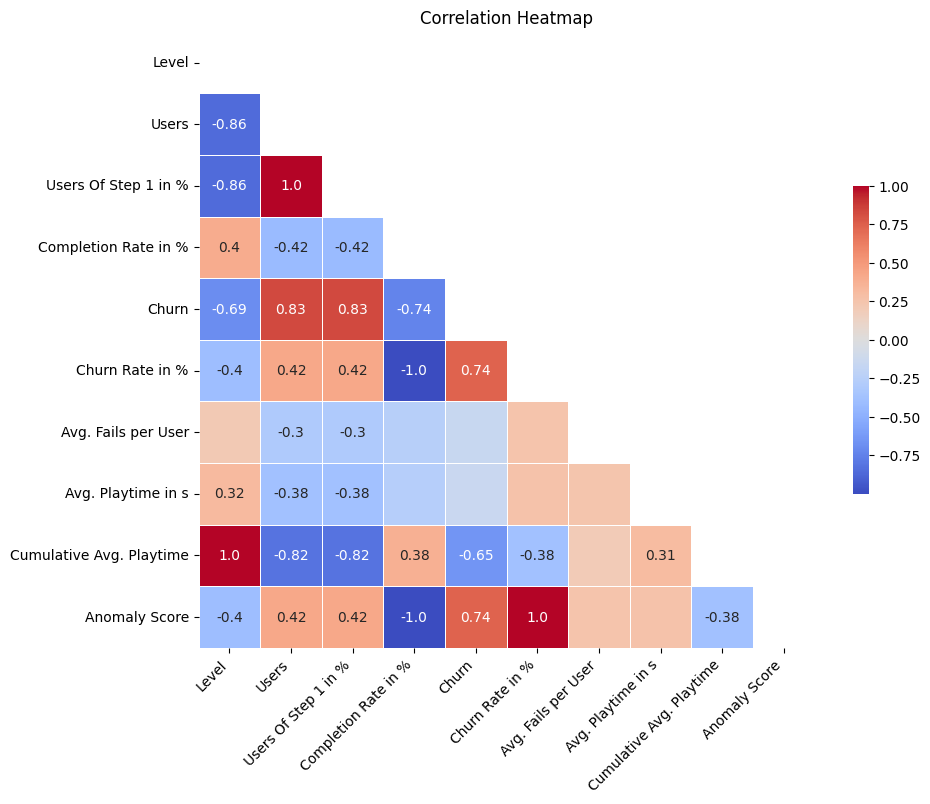

In [ ]:
# Correlation matrix for linear dependency.
correlation_matrix = data.corr(numeric_only=True)

# Mask
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

# Filter corr less than 0.3
annot_mask = (correlation_matrix <= -0.3) | (correlation_matrix >= 0.3)

# Annotations
annot_text = np.where(annot_mask, correlation_matrix.round(2).astype(str), '')

# Heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=annot_text, fmt='')

# Plot
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha='right')

plt.show()

 Data Distribution : Users


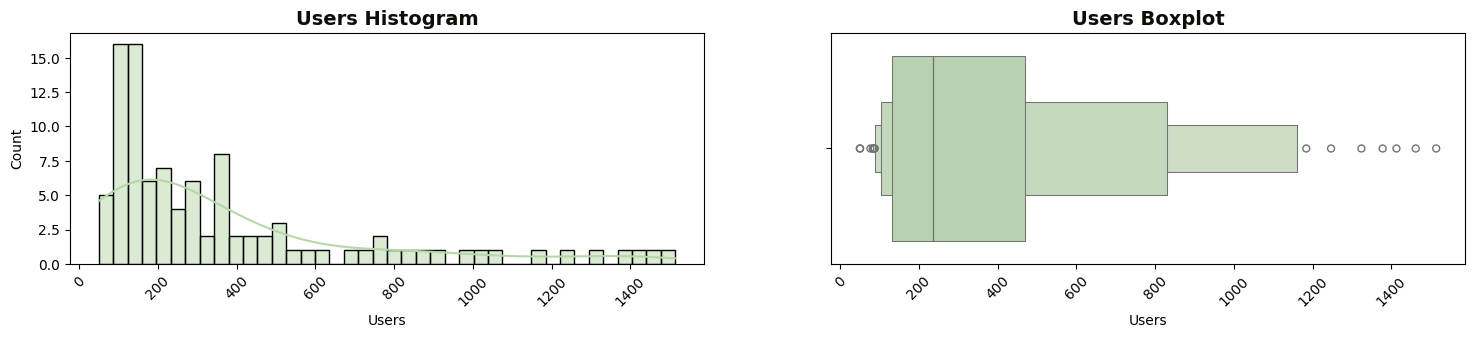



 Data Distribution : Users Of Step 1 in %


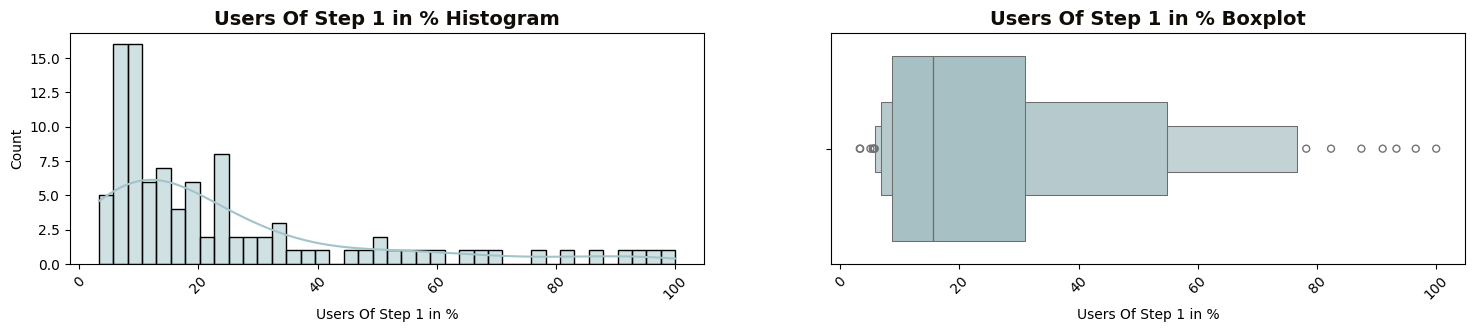



 Data Distribution : Completion Rate in %


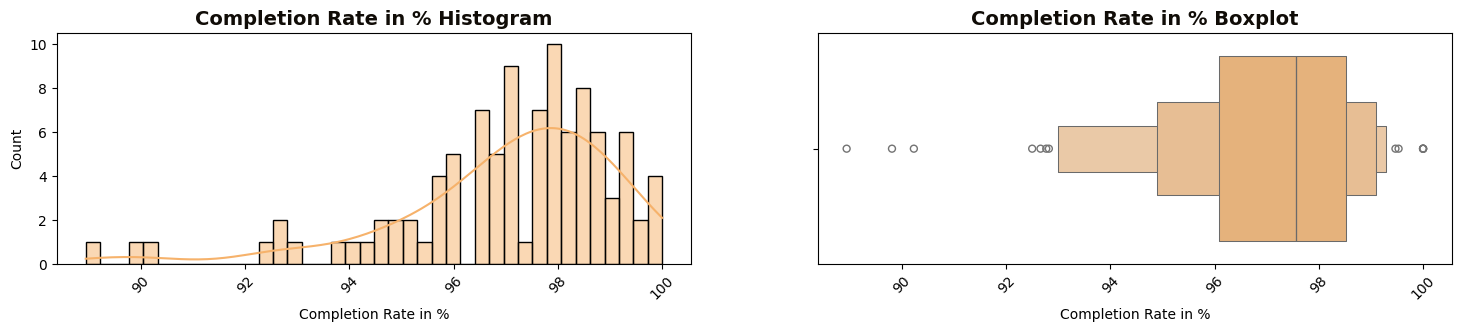



 Data Distribution : Churn


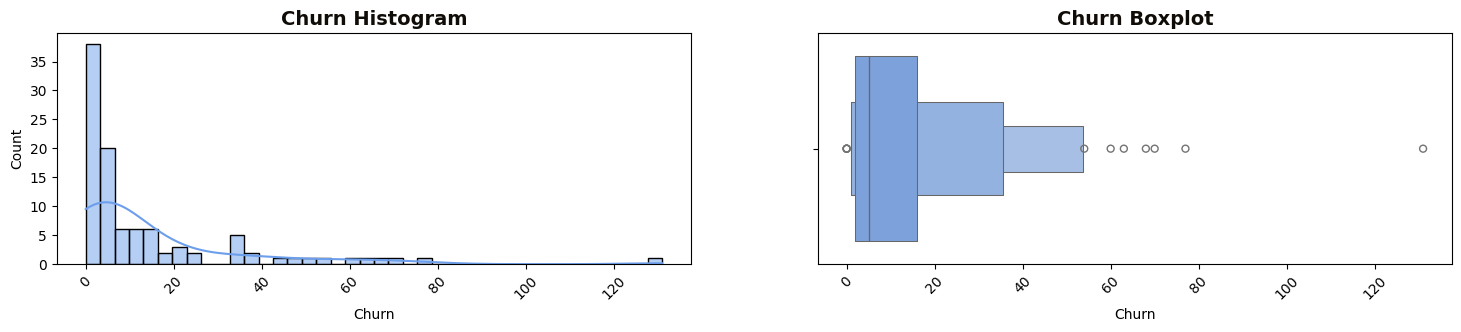



 Data Distribution : Churn Rate in %


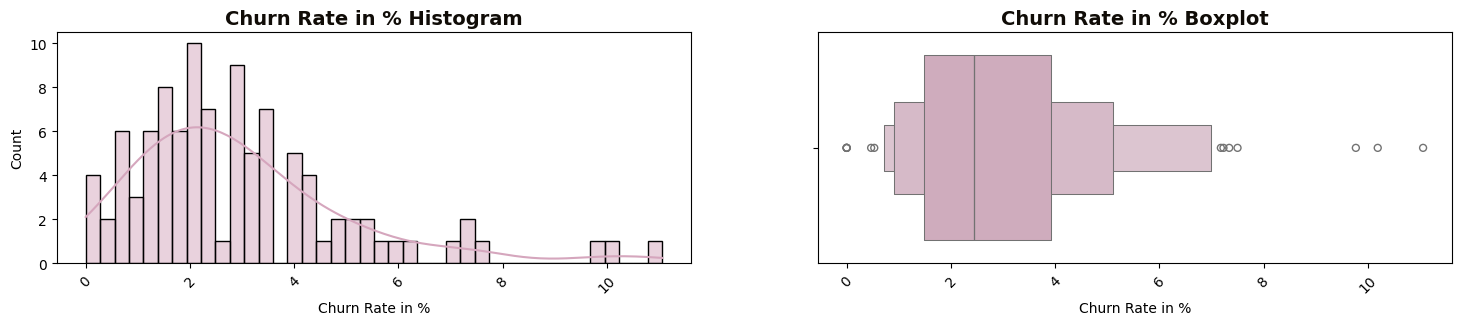



 Data Distribution : Avg. Fails per User


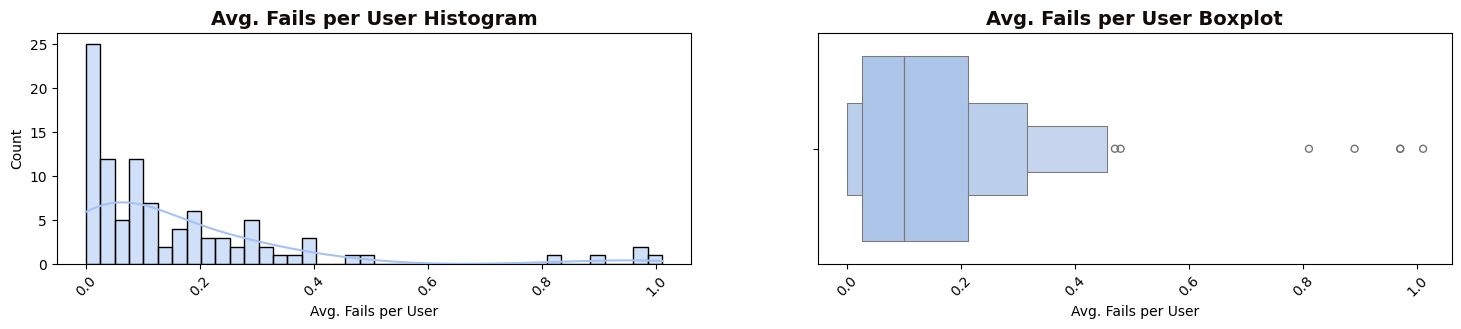



 Data Distribution : Avg. Playtime in s


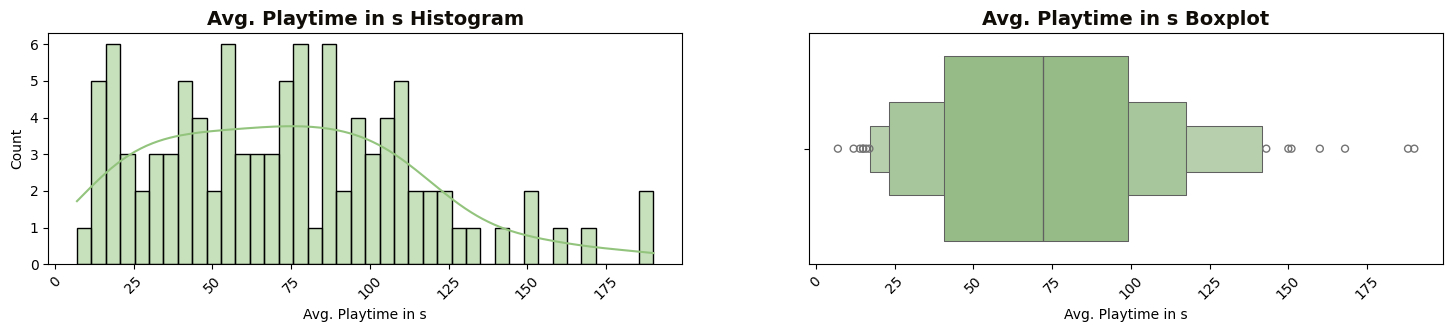



 Data Distribution : Anomaly Score


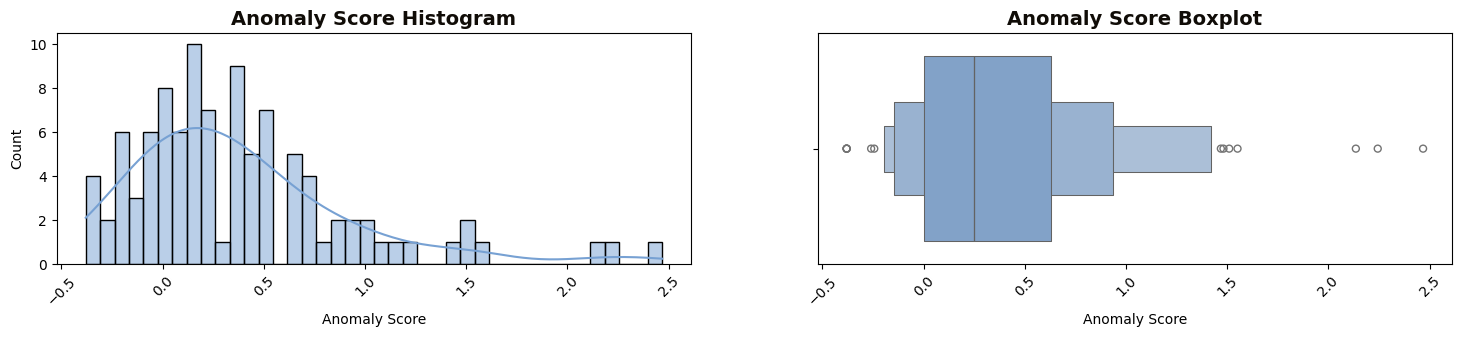

In [ ]:
# Creating color palette for visualization

color_palette = sns.color_palette(["#5A9", "#B6D7A8", "#A2C4C9",
                                   "#F6B26B", "#6D9EEB", "#D5A6BD",
                                   "#A4C2F4", "#93C47D", "#F9CB9C",
                                   "#8E7CC3", "#C27BA0", "#77A1D3",
                                   "#B4A7D6", "#A2C4C9", "#FFE599",
                                   "#E8B0D3", "#FFD700", "#87CEFA",
                                   "#32CD32", "#FFA07A", "#8A2BE2",
                                   "#5A9"
                                  ])

black_palette = ['#100C07', '#3E3B39', '#6D6A6A', '#9B9A9C', '#CAC9CD']

# Features
for color, column in enumerate(data.columns):
  if column == 'Level' or column == 'Cumulative Avg. Playtime' or column == 'UX Stage' or column == 'Stage Detail':
    continue
  else:
    print(f'\033[93m\033[1m Data Distribution : {column}\033[0m')
    plt.figure(figsize=(18, 3))
    plt.subplot(1, 2, 1)
    plt.title(f'{column} Histogram', fontweight = 'bold', fontsize = 14, fontfamily = 'sans-serif', color = black_palette[0])
    plt.tick_params(axis='x', rotation=45)
    sns.histplot(data[column], kde=True, bins=40, color = color_palette[color])
    plt.subplot(1, 2, 2)
    plt.title(f'{column} Boxplot', fontweight = 'bold', fontsize = 14, fontfamily = 'sans-serif', color = black_palette[0])
    plt.tick_params(axis='x', rotation=45)
    sns.boxenplot(data=data, x=column, color = color_palette[color])
    plt.show()
    print('\n')

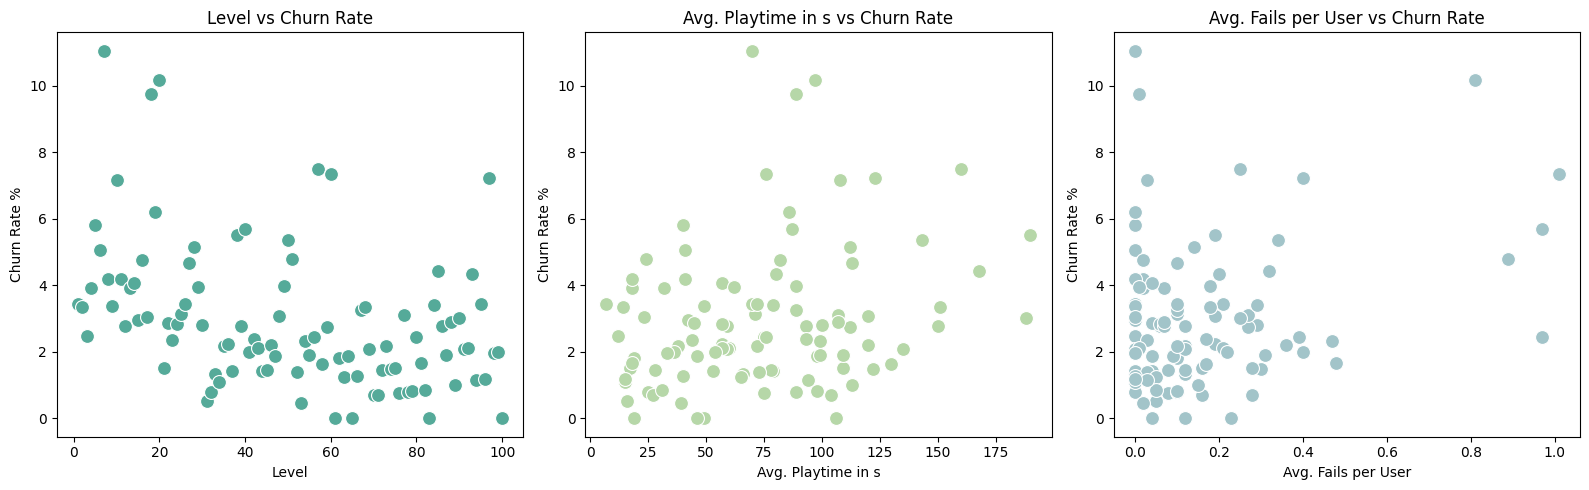

In [ ]:
# Axis grid
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plots
for i, feature in enumerate(['Level', 'Avg. Playtime in s', 'Avg. Fails per User']):
    sns.scatterplot(x=feature, y='Churn Rate in %', data=data, ax=axes[i], color=color_palette[i], s=100)
    axes[i].set_title(f'{feature} vs Churn Rate')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Churn Rate %')

plt.tight_layout()
plt.show()

**Level**

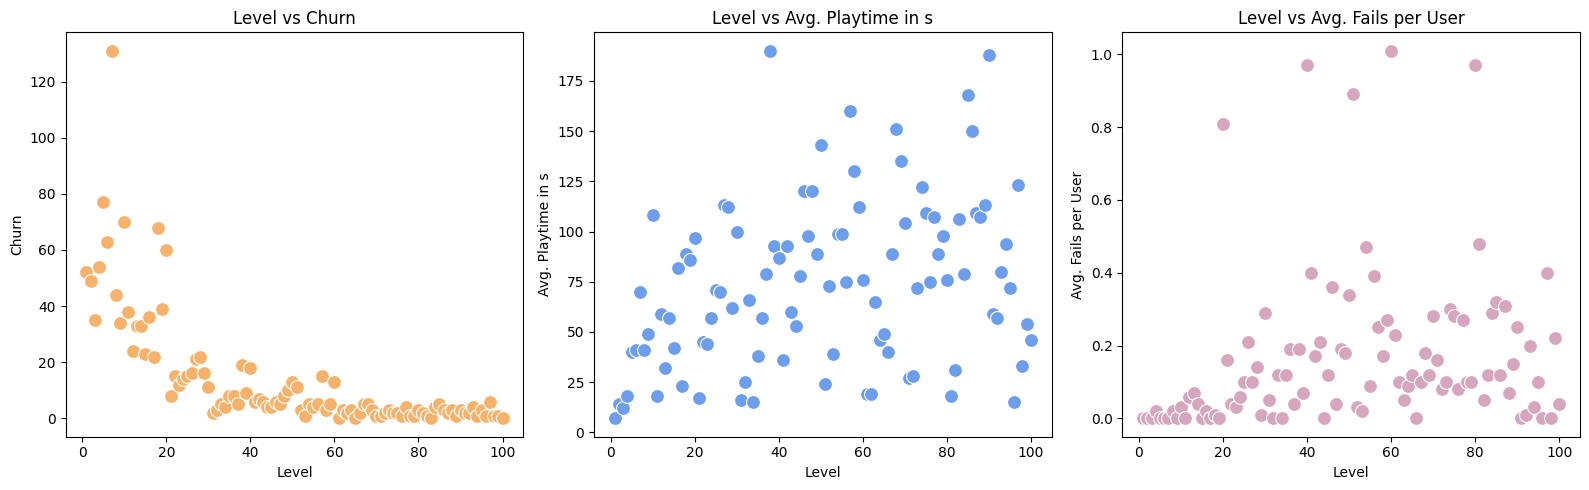

In [ ]:
# Axis grid
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot
for i, feature in enumerate(['Churn', 'Avg. Playtime in s', 'Avg. Fails per User']):
    sns.scatterplot(x='Level', y=feature, data=data, ax=axes[i], color=color_palette[3:][i], s=100)
    axes[i].set_title(f'Level vs {feature}')
    axes[i].set_xlabel('Level')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

**Findings:**

* The highest number of churned users is observed in levels below 20.
* With increasing levels, there is a noticeable rise in the average playtime (in seconds), accompanied by a wide range of values.
* Potential outliers in the average number of failures per user and churn rates have been identified.
* Data analysis indicates lower churn rates at higher levels, suggesting a more engaged player base in the advanced stages.
* The observed negative correlation with average playtime (in seconds) is not consistent, as the scatterplot does not support this pattern. We believe this is due to 3 observed outliers between 75 and 100 seconds of average playtime. In fact, a positive correlation emerges for levels where the average playtime exceeds 100 seconds.
* The Churn Rate Anomaly Score might be effectively set just below 1.5+ (according to the box plot) to identify anomalies.
* A churn rate of 55 could be considered high.(according to the box plot)

These insights will inform the optimization strategies concluded from our analysis.

<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">UX Stage Analysis</span>
</div>


In this section, we will leverage our bucketed data of average playtime in seconds categorized as User Experience (UX) Stages to identify the patterns easier.

**Churn vs UX Stage**

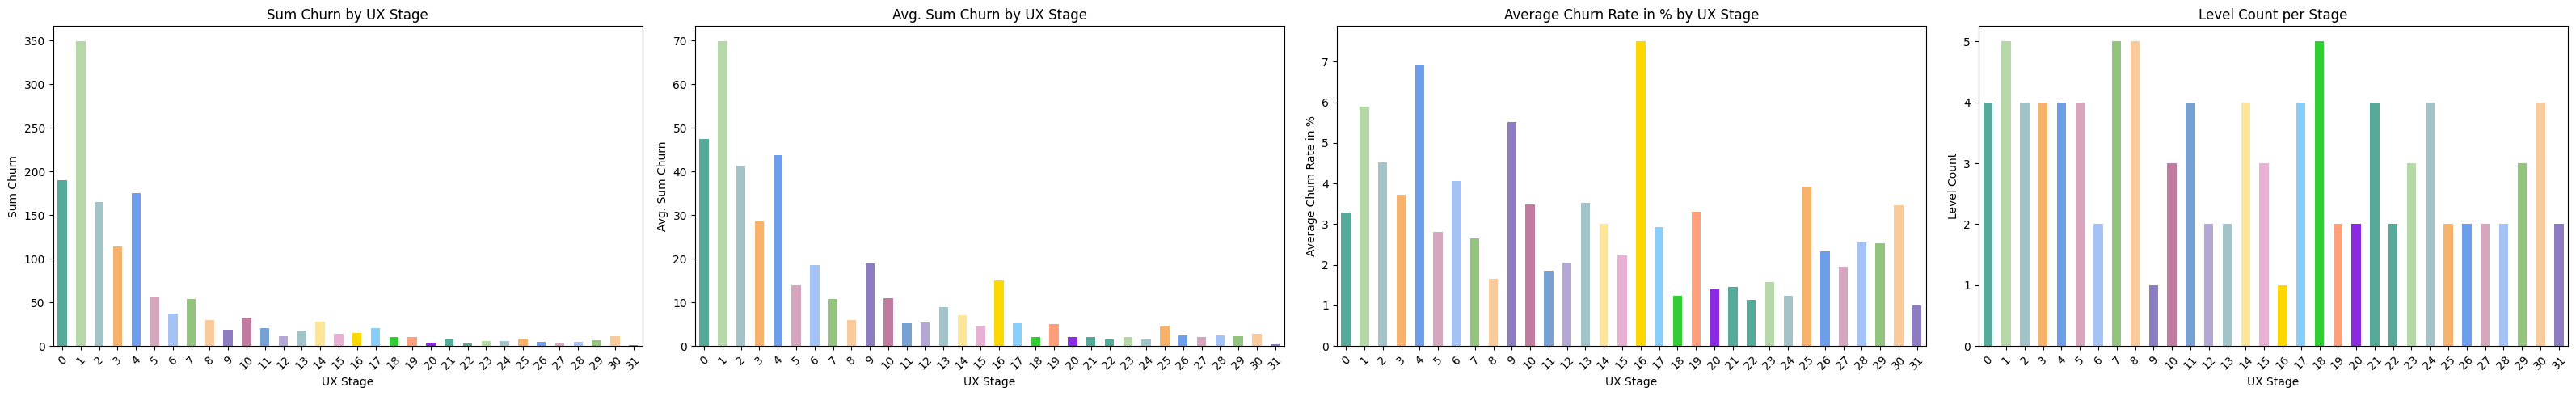

In [ ]:
data['UX Stage'] = data['UX Stage'].astype(int)
# Calculating averages for Churn, Churn Rate %, Playtime and Avg Fails
grouped_data_avg = data.groupby('UX Stage')[['Churn Rate in %', 'Churn', 'Avg. Playtime in s', 'Avg. Fails per User']].mean()
grouped_data_sum = data.groupby('UX Stage')['Churn'].sum()
grouped_data_count = data.groupby('UX Stage')['Level'].count()

# Plot
fig, axes = plt.subplots(1, 4, figsize=(32, 5))

# Sum of Churned Users
grouped_data_sum.plot(kind='bar', ax=axes[0], color=color_palette)
axes[0].set_title('Sum Churn by UX Stage')
axes[0].set_xlabel('UX Stage')
axes[0].set_ylabel('Sum Churn')
axes[0].tick_params(axis='x', rotation=45)

# Avg Sum of Churned Users
grouped_data_avg['Churn'].plot(kind='bar', ax=axes[1], color=color_palette)
axes[1].set_title('Avg. Sum Churn by UX Stage')
axes[1].set_xlabel('UX Stage')
axes[1].set_ylabel('Avg. Sum Churn')
axes[1].tick_params(axis='x', rotation=45)

# Avg Churn Rate
grouped_data_avg['Churn Rate in %'].plot(kind='bar', ax=axes[2], color=color_palette)
axes[2].set_title('Average Churn Rate in % by UX Stage')
axes[2].set_xlabel('UX Stage')
axes[2].set_ylabel('Average Churn Rate in %')
axes[2].tick_params(axis='x', rotation=45)

# Level Count
grouped_data_count.plot(kind='bar', ax=axes[3], color=color_palette)
axes[3].set_title('Level Count per Stage')
axes[3].set_xlabel('UX Stage')
axes[3].set_ylabel('Level Count')
axes[3].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

**Difficulty vs UX Stage**

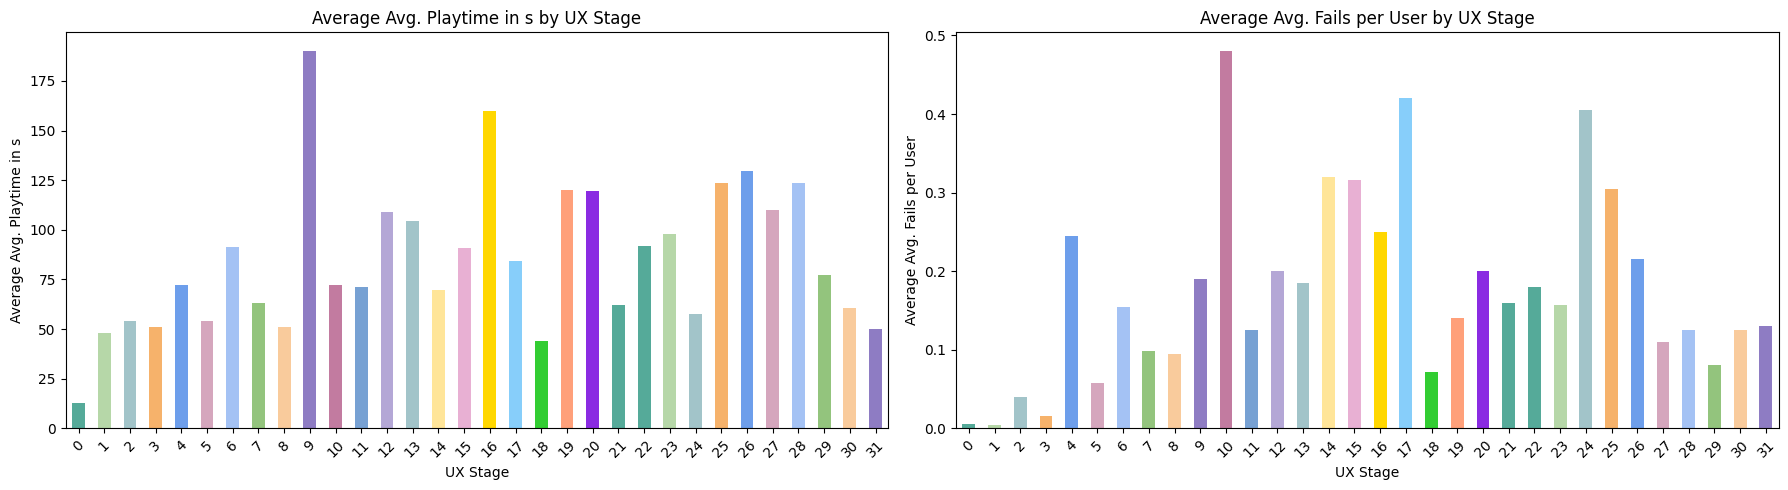

In [ ]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 5))


for i, feature in enumerate(['Avg. Playtime in s', 'Avg. Fails per User']):
    ordered_grouped_data_avg = grouped_data_avg
    ordered_grouped_data_avg[feature].plot(kind='bar', ax=axes[i], color=color_palette)
    axes[i].set_title(f'Average {feature} by UX Stage')
    axes[i].set_xlabel('UX Stage')
    axes[i].set_ylabel(f'Average {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

UX Stage 0, 1, 2 and 4 Levels

In [ ]:
data[data['UX Stage'].isin([0, 1, 2, 4])]

,Level,Users,Users Of Step 1 in %,Completion Rate in %,Churn,Churn Rate in %,Avg. Fails per User,Avg. Playtime in s,Cumulative Avg. Playtime,UX Stage,Stage Detail,Anomaly Score
0,1,1514,100.00,96.57,52,3.43,0.00,7,7,0,FTUE,0.503095
1,2,1462,96.57,96.65,49,3.35,0.00,14,21,0,FTUE,0.482496
2,3,1413,93.33,97.52,35,2.48,0.00,12,33,0,FTUE,0.258481
3,4,1378,91.02,96.08,54,3.92,0.02,18,51,0,FTUE,0.629264
4,5,1324,87.45,94.18,77,5.82,0.00,40,91,1,"Stage 1 Range: (60,300]",1.118493
5,6,1247,82.36,94.95,63,5.05,0.00,41,132,1,"Stage 1 Range: (60,300]",0.920227
6,7,1184,78.20,88.94,131,11.06,0.00,70,202,1,"Stage 1 Range: (60,300]",2.467734
7,8,1053,69.55,95.82,44,4.18,0.02,41,243,1,"Stage 1 Range: (60,300]",0.696211
8,9,1009,66.64,96.63,34,3.37,0.00,49,292,1,"Stage 1 Range: (60,300]",0.487646
9,10,975,64.40,92.82,70,7.18,0.03,108,400,2,"Stage 2 Range: (300,600]",1.468677


<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">UX Stage Optimization</span>
</div>


**UX Stage Optimizations:**

* The significant number of churned users in the first 4 UX Stages highlights crucial areas for enhancing user retention. The focus will be on Stages 0 (FTUE), 1, 2, and 4.

* No churn rate anomalies observed for FTUE. Further recommendations should be decided by the product analysis.

* The substantial increase in playtime from FTUE to Stage 1, from an average of 12.75 seconds to 48.20 seconds, suggests a steep learning curve that may deter new players. To mitigate churn, it is advisable to modify Stage 1 to achieve an average playtime of 27 seconds through level adjustments, aiming for a more gradual increase in playtime.

  * To achieve this outcome, we will undertake a rebalancing of levels 5, 6, 7, 8, and 9. The objective is to adjust the average playtimes for these levels to 23 seconds for levels 5, 6, and 8, 39 seconds for level 7, and 28 seconds for level 9. These adjustments will be contingent upon a thorough analysis of the monetization performance associated with these levels.


* Given the observations for UX Stage 2, Level 10, where the level is marginally above the anomaly score and introduces significant gameplay changes such as the "turn the table" function and a substantial increase in the number of tiles. Reducing the introduction animation duration and tile count could help reducing the churn. No other action points on UX Stage 2.

* The higher average fails per user observed in Stage 4 points to a significant spike in difficulty, likely contributing to increased churn rates. To address this, it is recommended to reduce the average fails per user to 0.15, thereby smoothing the difficulty curve and enhancing player retention.

  * To achieve this outcome, Level 20 will undergo a modification aimed at reducing the average fails per user to 0.5. This change is intended to decrease churn rates while still preserving the level's challenging nature.

<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Level Analysis</span>
</div>


In this section, we will conduct a level-based visualization for a detailed analysis of individual game levels. We will utilize the Plotly library to create interactive plots, where hovering over the markers will display detailed information about each level, including level specifics and the total churn.

Level vs Churn

In [ ]:
# Line Chart Churn
fig = px.line(data, x='Level', y='Churn', markers=True,
              title='Interactive Plot - Sum of Churned Users by Level',
              labels={'Churn': 'Sum of Churn', 'Level': 'Level'},
              line_shape='spline')

# Update Layout
fig.update_layout(
    xaxis_title='Level',
    yaxis_title='Sum of Churn',
    xaxis_tickangle=-45,
)

fig.show()

# Line Chart Churn Rate in %

fig = px.line(data, x='Level', y='Churn Rate in %', markers=True,
              title='Interactive Plot - Churn Rate in % by Level',
              labels={'Churn Rate in %': 'Sum of Churn Rate in %', 'Level': 'Level'},
              line_shape='spline')

# Update Layout
fig.update_layout(
    xaxis_title='Level',
    yaxis_title='Churn Rate in %',
    xaxis_tickangle=-45,
)

fig.show()


If you are viewing this notebook on GitHub, you can Click here to view the interactive plots.

Level vs Difficulty

In [ ]:
# Line Chart Avg. Playtime in s
fig = px.line(data, x='Level', y='Avg. Playtime in s', markers=True,
              title='Interactive Plot - Avg. Playtime in s by Level',
              labels={'Avg. Playtime in s': 'Avg. Playtime in s', 'Level': 'Level'},
              line_shape='spline')  # Makes the line smooth

# Update Layout
fig.update_layout(
    xaxis_title='Level',
    yaxis_title='Avg. Playtime in s',
    xaxis_tickangle=-45,
)

fig.show()

# Line Chart Avg. Fails per User
fig = px.line(data, x='Level', y='Avg. Fails per User', markers=True,
              title='Interactive Plot - Avg. Fails per User by Level',
              labels={'Avg. Fails per User': 'Avg. Fails per User', 'Level': 'Level'},
              line_shape='spline')  # Makes the line smooth

# Update Layout
fig.update_layout(
    xaxis_title='Level',
    yaxis_title='Avg. Fails per User',
    xaxis_tickangle=-45,
)

fig.show()

If you are viewing this notebook on GitHub, you can Click here to view the interactive plots.

Levels Counted as Anomalies

In [ ]:
data[(data['Anomaly_Score'] > 1.45) | (data['Churn'] > 55)]

,Level,Users,Users Of Step 1 in %,Completion Rate in %,Churn,Churn Rate in %,Avg. Fails per User,Avg. Playtime in s,Cumulative Avg. Playtime,UX Stage,Stage Detail,Anomaly_Score
4,5,1324,87.45,94.18,77,5.82,0.00,40,91,1,"Stage 1 Range: (60,300]",1.118493
5,6,1247,82.36,94.95,63,5.05,0.00,41,132,1,"Stage 1 Range: (60,300]",0.920227
6,7,1184,78.20,88.94,131,11.06,0.00,70,202,1,"Stage 1 Range: (60,300]",2.467734
9,10,975,64.40,92.82,70,7.18,0.03,108,400,2,"Stage 2 Range: (300,600]",1.468677
17,18,696,45.97,90.23,68,9.77,0.01,89,802,4,"Stage 4 Range: (780,1200]",2.135573
19,20,589,38.90,89.81,60,10.19,0.81,97,985,4,"Stage 4 Range: (780,1200]",2.243718
56,57,200,13.21,92.50,15,7.50,0.25,160,3801,16,"Stage 16 Range: (3660,4800]",1.551074
59,60,177,11.69,92.66,13,7.34,1.01,76,4119,17,"Stage 17 Range: (3900,5100]",1.509876
96,97,83,5.48,92.77,6,7.23,0.40,123,7208,30,"Stage 30 Range: (7020,9000]",1.481552


<div style="background-color: #006400; padding: 10px; border-radius: 5px;">
    <span style="color: white; font-size: 28px; font-weight: bold;">Level Optimization</span>
</div>


**Level Optimizations:**

For the initial 100 levels, attention will be particularly directed towards levels 5, 6, 7, 10, 20, 38, 40, 57, 60, and 97, based on our anomaly metric, churn count, product analysis, and graphical data review.


Level 5: Despite average fails per user and playtime appearing normal, a perceived increase in difficulty was noted during product analysis, possibly due to more colors and tiles on the map. It's advised to introduce more colors but maintain a lower tile count to manage difficulty levels.

Level 6: The introduction of red tiles created a fake difficulty spike feeling during the product analysis, suggesting a need for further analysis of this change's impact.

Level 7: This level forcing players to introduce the kitchen, kitchen decorations, brush currency, and the main menu, diverting them from the core gameplay to learn about these new elements.

  * New UX designs could be implemented to streamline the introduction of game concepts, or the optionality of these introductions could be tested to enhance the player experience.

  * Introducing new power-ups has been observed to negatively impact churn and churn rates. Integrating the tutorial with the introduction of a new power-up might help in reducing churn metrics.

  * Avg playtime in s will be reduced in this level as mentioned in UX Stage action points.

Level 10: The introduction of the 'turning the table' feature and a subsequent difficulty spike were observed during product analysis. Shortening the tutorial animation and reducing the average playtime to 82 seconds are recommended to  smooth the difficulty increase.

Level 20: With a higher average number of fails per user noted at this level, it's recommended to reduce this metric to 0.5 fails per user to normalize the difficulty.

Level 38: This level shows an increase in average playtime, suggesting a need to decrease this metric to 100 seconds for a more balanced gameplay experience. This is concluded from the positive correlation of churn rates and avg playtime in s after 100 seconds of playtime.

Level 40: Recommended to lower the average fails per user to 0.6 to normalize gameplay difficulty targeting to reduce churn rates.

Level 51: Recommended to lower the average fails per user to 0.6 to normalize gameplay difficulty targeting to reduce churn rates.

Level 57: Recommended to lower the average play time in s to 100 seconds to normalize playtime targeting to reduce churn rates.

Level 60: Recommended to lower the average fails per user to 0.6 to normalize gameplay difficulty targeting to reduce churn rates.